Training DQN agent...


C:\Users\alyhi\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10/300, Avg Reward: 18.00, Epsilon: 0.95, Time: 0.7s
Episode 20/300, Avg Reward: 20.40, Epsilon: 0.90, Time: 1.6s
Episode 30/300, Avg Reward: 35.20, Epsilon: 0.86, Time: 3.2s
Episode 40/300, Avg Reward: 31.10, Epsilon: 0.82, Time: 4.7s
Episode 50/300, Avg Reward: 51.00, Epsilon: 0.78, Time: 7.4s
Episode 60/300, Avg Reward: 47.40, Epsilon: 0.74, Time: 9.7s
Episode 70/300, Avg Reward: 31.90, Epsilon: 0.70, Time: 11.2s
Episode 80/300, Avg Reward: 30.70, Epsilon: 0.67, Time: 12.8s
Episode 90/300, Avg Reward: 39.20, Epsilon: 0.64, Time: 14.9s
Episode 100/300, Avg Reward: 48.90, Epsilon: 0.61, Time: 17.3s
Episode 110/300, Avg Reward: 33.80, Epsilon: 0.58, Time: 19.0s
Episode 120/300, Avg Reward: 27.70, Epsilon: 0.55, Time: 20.4s
Episode 130/300, Avg Reward: 31.60, Epsilon: 0.52, Time: 21.9s
Episode 140/300, Avg Reward: 29.70, Epsilon: 0.50, Time: 23.4s
Episode 150/300, Avg Reward: 58.70, Epsilon: 0.47, Time: 26.5s
Episode 160/300, Avg Reward: 49.00, Epsilon: 0.45, Time: 28.9s
Episode

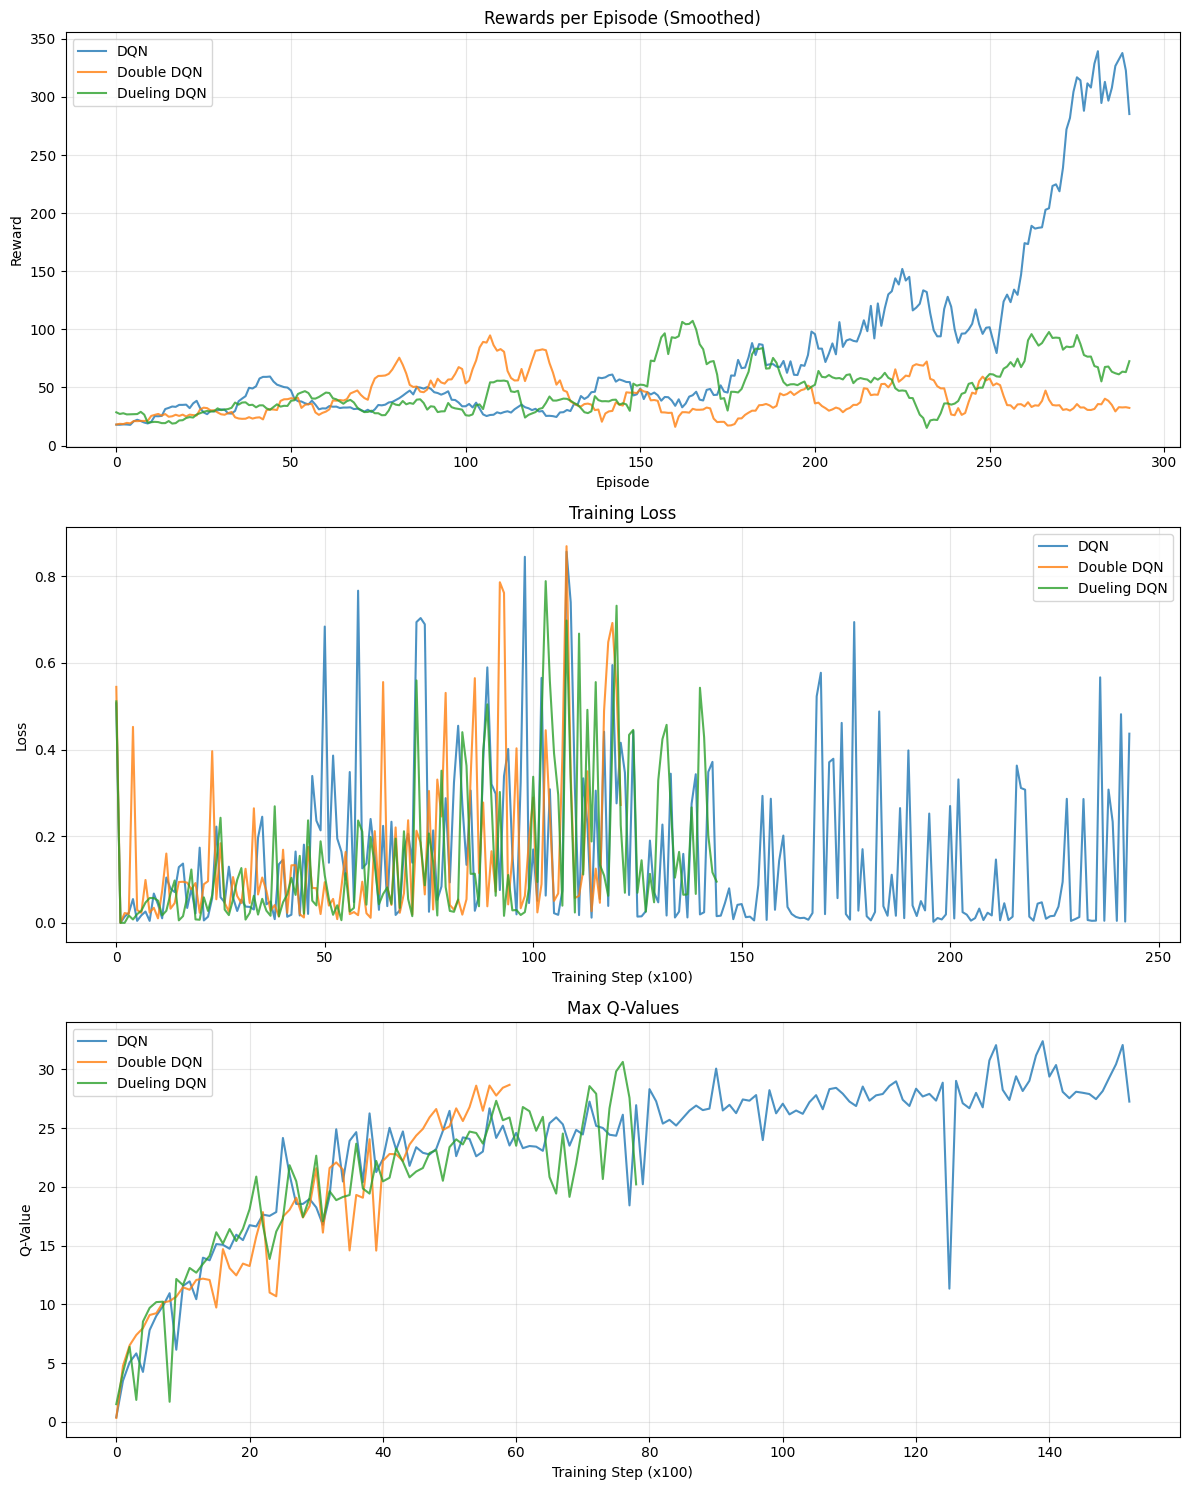

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import time

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Experience Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# 1. Standard DQN Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 2. Dueling DQN Network
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        # Shared feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Combine value and advantages to get Q-values
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        return value + (advantages - advantages.mean(dim=1, keepdim=True))

# DQN Agent class (base class for all implementations)
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 memory_size=10000, batch_size=64, target_update=10,
                 model_type="DQN"):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma  # discount factor
        
        # Epsilon parameters for exploration
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Replay memory parameters
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        
        # Network parameters
        self.lr = lr
        self.target_update = target_update
        self.model_type = model_type
        
        # Initialize networks
        if model_type == "DQN" or model_type == "DoubleDQN":
            self.policy_net = DQN(state_dim, action_dim).to(device)
            self.target_net = DQN(state_dim, action_dim).to(device)
        elif model_type == "DuelingDQN":
            self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
            self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        # Tracking metrics
        self.losses = []
        self.q_values = []
        self.rewards = []
        
    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                self.q_values.append(q_values.max().item())  # Track max Q-value
                return q_values.max(1)[1].item()
    
    def update_epsilon(self):
        # Decay epsilon after each episode
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def store_transition(self, state, action, reward, next_state, done):
        # Store transition in replay memory
        self.memory.push(state, action, reward, next_state, done)
    
    def update_model(self):
        if len(self.memory) < self.batch_size:
            return 0  # Not enough samples for an update
        
        # Sample batch from replay memory
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert to tensors
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(np.array(batch.done)).unsqueeze(1).to(device)
        
        # Compute current Q-values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute target Q-values (different for each algorithm)
        with torch.no_grad():
            if self.model_type == "DQN":
                # Standard DQN: max Q-value from target network
                next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
                
            elif self.model_type == "DoubleDQN":
                # Double DQN: use policy network to select action, target network to evaluate
                next_actions = self.policy_net(next_state_batch).max(1, keepdim=True)[1]
                next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
                
            elif self.model_type == "DuelingDQN":
                # Dueling DQN uses the same target calculation as the base model type
                # The difference is in the network architecture, not the training algorithm
                next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Compute loss and optimize
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Track loss
        self.losses.append(loss.item())
        
        return loss.item()
    
    def update_target_network(self):
        # Update target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    def train(self, env, num_episodes, max_steps=500):
        """Train the agent for a specified number of episodes"""
        total_rewards = []
        episode_durations = []
        start_time = time.time()
        
        for episode in range(num_episodes):
            state, _ = env.reset()
            episode_reward = 0
            
            for step in range(max_steps):
                # Select and perform action
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                # Store transition
                self.store_transition(state, action, reward, next_state, done)
                
                # Update state and accumulate reward
                state = next_state
                episode_reward += reward
                
                # Optimize model
                loss = self.update_model()
                
                # Check if episode is done
                if done:
                    break
            
            # Update target network periodically
            if episode % self.target_update == 0:
                self.update_target_network()
            
            # Update epsilon
            self.update_epsilon()
            
            # Track rewards
            total_rewards.append(episode_reward)
            episode_durations.append(step + 1)
            self.rewards.append(episode_reward)
            
            # Print progress
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(total_rewards[-10:])
                print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, "
                      f"Epsilon: {self.epsilon:.2f}, Time: {time.time() - start_time:.1f}s")
        
        elapsed_time = time.time() - start_time
        print(f"Training complete in {elapsed_time:.2f} seconds")
        
        return total_rewards, episode_durations

# Function to compare models
def compare_models(env_name="CartPole-v1", num_episodes=300):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Create agents with the same hyperparameters
    dqn_agent = DQNAgent(state_dim, action_dim, model_type="DQN")
    double_dqn_agent = DQNAgent(state_dim, action_dim, model_type="DoubleDQN")
    dueling_dqn_agent = DQNAgent(state_dim, action_dim, model_type="DuelingDQN")
    
    # Train agents
    print("Training DQN agent...")
    dqn_rewards, dqn_durations = dqn_agent.train(env, num_episodes)
    
    print("\nTraining Double DQN agent...")
    double_dqn_rewards, double_dqn_durations = double_dqn_agent.train(env, num_episodes)
    
    print("\nTraining Dueling DQN agent...")
    dueling_dqn_rewards, dueling_dqn_durations = dueling_dqn_agent.train(env, num_episodes)
    
    # Plot results
    plot_results(dqn_rewards, double_dqn_rewards, dueling_dqn_rewards, 
                dqn_agent.losses, double_dqn_agent.losses, dueling_dqn_agent.losses,
                dqn_agent.q_values, double_dqn_agent.q_values, dueling_dqn_agent.q_values)
    
    return dqn_agent, double_dqn_agent, dueling_dqn_agent

def plot_results(dqn_rewards, double_dqn_rewards, dueling_dqn_rewards, 
                 dqn_losses, double_dqn_losses, dueling_dqn_losses,
                 dqn_q_values, double_dqn_q_values, dueling_dqn_q_values):
    # Smooth rewards for better visualization
    def moving_average(data, window_size=10):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window = 10
    dqn_rewards_smooth = moving_average(dqn_rewards, window)
    double_dqn_rewards_smooth = moving_average(double_dqn_rewards, window)
    dueling_dqn_rewards_smooth = moving_average(dueling_dqn_rewards, window)
    
    # Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot rewards
    axs[0].plot(dqn_rewards_smooth, label='DQN', alpha=0.8)
    axs[0].plot(double_dqn_rewards_smooth, label='Double DQN', alpha=0.8)
    axs[0].plot(dueling_dqn_rewards_smooth, label='Dueling DQN', alpha=0.8)
    axs[0].set_title('Rewards per Episode (Smoothed)')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # Plot losses
    axs[1].plot(dqn_losses[::100], label='DQN', alpha=0.8)  # Sample every 100th loss for clarity
    axs[1].plot(double_dqn_losses[::100], label='Double DQN', alpha=0.8)
    axs[1].plot(dueling_dqn_losses[::100], label='Dueling DQN', alpha=0.8)
    axs[1].set_title('Training Loss')
    axs[1].set_xlabel('Training Step (x100)')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    # Plot Q-values
    axs[2].plot(dqn_q_values[::100], label='DQN', alpha=0.8)  # Sample every 100th Q-value
    axs[2].plot(double_dqn_q_values[::100], label='Double DQN', alpha=0.8)
    axs[2].plot(dueling_dqn_q_values[::100], label='Dueling DQN', alpha=0.8)
    axs[2].set_title('Max Q-Values')
    axs[2].set_xlabel('Training Step (x100)')
    axs[2].set_ylabel('Q-Value')
    axs[2].legend()
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rl_comparison_results.png')
    plt.show()

if __name__ == "__main__":
    compare_models(env_name="CartPole-v1", num_episodes=300)

# Bonus

Training DuelingDQN agent without prioritized replay...


C:\Users\alyhi\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10/200, Avg Reward: 24.40, Epsilon: 0.95, Time: 1.5s
Episode 20/200, Avg Reward: 24.00, Epsilon: 0.90, Time: 3.4s
Episode 30/200, Avg Reward: 19.30, Epsilon: 0.86, Time: 4.9s
Episode 40/200, Avg Reward: 22.70, Epsilon: 0.82, Time: 6.8s
Episode 50/200, Avg Reward: 36.50, Epsilon: 0.78, Time: 9.8s
Episode 60/200, Avg Reward: 29.70, Epsilon: 0.74, Time: 12.2s
Episode 70/200, Avg Reward: 43.00, Epsilon: 0.70, Time: 15.8s
Episode 80/200, Avg Reward: 30.40, Epsilon: 0.67, Time: 18.4s
Episode 90/200, Avg Reward: 26.10, Epsilon: 0.64, Time: 20.6s
Episode 100/200, Avg Reward: 40.30, Epsilon: 0.61, Time: 24.0s
Episode 110/200, Avg Reward: 41.10, Epsilon: 0.58, Time: 27.5s
Episode 120/200, Avg Reward: 50.70, Epsilon: 0.55, Time: 31.7s
Episode 130/200, Avg Reward: 54.80, Epsilon: 0.52, Time: 36.4s
Episode 140/200, Avg Reward: 84.40, Epsilon: 0.50, Time: 43.6s
Episode 150/200, Avg Reward: 42.90, Epsilon: 0.47, Time: 47.2s
Episode 160/200, Avg Reward: 51.00, Epsilon: 0.45, Time: 51.6s
Episod

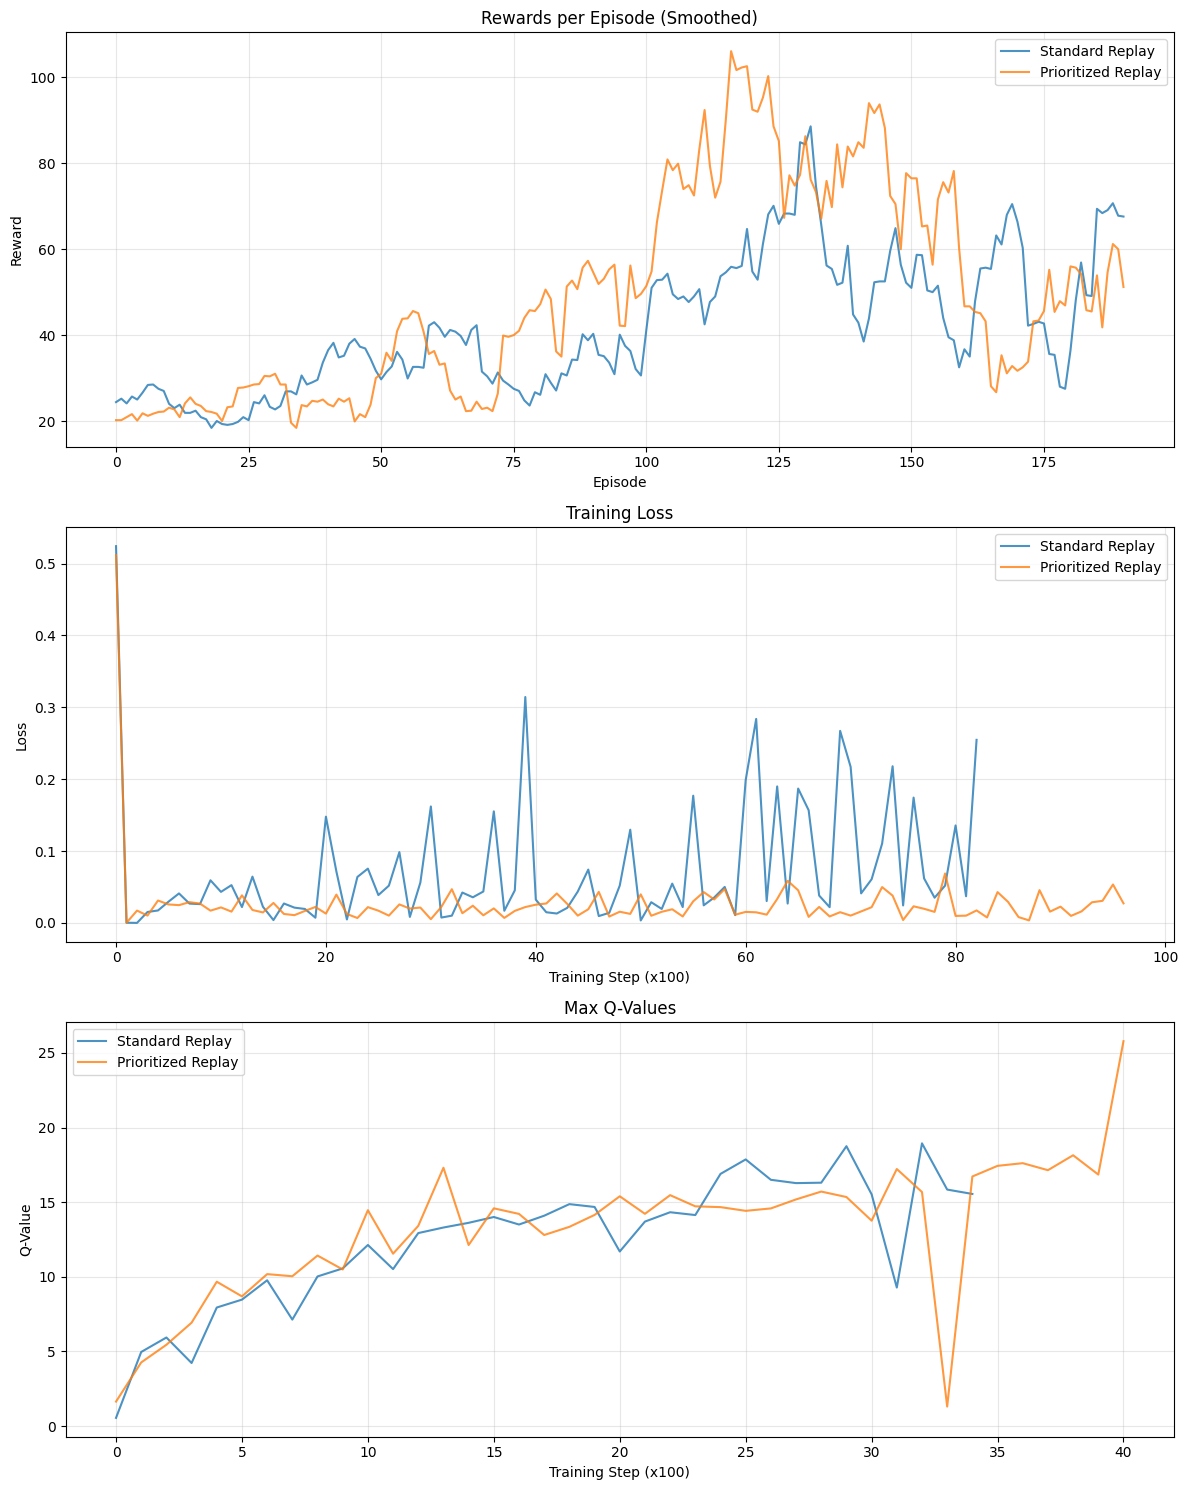

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import time

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Experience Replay Memory with Prioritization
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_end=1.0, beta_frames=10000):
        self.capacity = capacity
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha  # Priority exponent (how much to prioritize)
        self.beta = beta_start  # Importance sampling weight exponent
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_frames = beta_frames
        self.max_priority = 1.0  # Start with max priority for new transitions
        
    def update_beta(self, frame_idx):
        # Linearly anneal beta from beta_start to beta_end over beta_frames steps
        self.beta = min(self.beta_end, self.beta_start + frame_idx * (self.beta_end - self.beta_start) / self.beta_frames)
        
    def push(self, *args):
        # Add new transition with max priority
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        
        # New experiences are given max priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.memory) < self.capacity:
            probs = self.priorities[:len(self.memory)] ** self.alpha
        else:
            probs = self.priorities ** self.alpha
        
        # Normalize probabilities to sum to 1
        probs /= probs.sum()
        
        # Sample indices based on probabilities
        indices = np.random.choice(len(self.memory), batch_size, p=probs[:len(self.memory)])
        
        # Calculate importance sampling weights
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        # Normalize weights to have max weight = 1
        weights /= weights.max()
        weights = torch.FloatTensor(weights).to(device)
        
        # Get the batch of transitions
        batch = [self.memory[idx] for idx in indices]
        
        return batch, indices, weights
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            # Update max priority for future transitions
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.memory)

# Define standard ReplayMemory (non-prioritized) for comparison
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        return transitions, None, None  # Match PrioritizedReplayMemory interface
    
    def update_priorities(self, indices, priorities):
        # No-op for standard replay memory
        pass
    
    def update_beta(self, frame_idx):
        # No-op for standard replay memory
        pass
    
    def __len__(self):
        return len(self.memory)

# Define named tuple for storing transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

# DQN Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Dueling DQN Network
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        # Shared feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Combine value and advantages to get Q-values
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        return value + (advantages - advantages.mean(dim=1, keepdim=True))

# DQN Agent with or without prioritized replay
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 memory_size=10000, batch_size=64, target_update=10,
                 model_type="DQN", prioritized_replay=False):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma  # discount factor
        
        # Epsilon parameters for exploration
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Replay memory parameters
        self.batch_size = batch_size
        self.prioritized_replay = prioritized_replay
        
        # Initialize replay memory
        if prioritized_replay:
            self.memory = PrioritizedReplayMemory(memory_size)
        else:
            self.memory = ReplayMemory(memory_size)
        
        # Network parameters
        self.lr = lr
        self.target_update = target_update
        self.model_type = model_type
        
        # Initialize networks
        if model_type == "DQN" or model_type == "DoubleDQN":
            self.policy_net = DQN(state_dim, action_dim).to(device)
            self.target_net = DQN(state_dim, action_dim).to(device)
        elif model_type == "DuelingDQN":
            self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
            self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        # Tracking metrics
        self.losses = []
        self.q_values = []
        self.rewards = []
        self.frame_idx = 0
        
    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                self.q_values.append(q_values.max().item())  # Track max Q-value
                return q_values.max(1)[1].item()
    
    def update_epsilon(self):
        # Decay epsilon after each episode
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def store_transition(self, state, action, reward, next_state, done):
        # Store transition in replay memory
        self.memory.push(state, action, reward, next_state, done)
        self.frame_idx += 1
        # Update beta parameter for prioritized replay
        self.memory.update_beta(self.frame_idx)
    
    def update_model(self):
        if len(self.memory) < self.batch_size:
            return 0  # Not enough samples for an update
        
        # Sample batch from replay memory
        transitions, indices, weights = self.memory.sample(self.batch_size)
        
        if self.prioritized_replay:
            batch = Transition(*zip(*transitions))
        else:
            batch = Transition(*zip(*transitions))
            weights = torch.ones(self.batch_size).to(device)  # Equal weights for non-prioritized
        
        # Convert to tensors
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(np.array(batch.done)).unsqueeze(1).to(device)
        
        # Compute current Q-values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute target Q-values (different for each algorithm)
        with torch.no_grad():
            if self.model_type == "DQN":
                # Standard DQN: max Q-value from target network
                next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
                
            elif self.model_type == "DoubleDQN":
                # Double DQN: use policy network to select action, target network to evaluate
                next_actions = self.policy_net(next_state_batch).max(1, keepdim=True)[1]
                next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
                
            elif self.model_type == "DuelingDQN":
                # Dueling DQN uses the same target calculation as the base model type
                # The difference is in the network architecture, not the training algorithm
                next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
                target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Compute TD errors for prioritized replay
        td_errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()
        
        # Compute weighted MSE loss
        if self.prioritized_replay:
            # Element-wise weighted loss
            losses = F.smooth_l1_loss(current_q_values, target_q_values, reduction='none')
            loss = (losses * weights.unsqueeze(1)).mean()
        else:
            # Standard loss
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities in memory
        if self.prioritized_replay and indices is not None:
            # Use TD errors as priorities
            # Add small constant to prevent edge case of zero priority
            priorities = td_errors.flatten() + 1e-5
            self.memory.update_priorities(indices, priorities)
        
        # Track loss
        self.losses.append(loss.item())
        
        return loss.item()
    
    def update_target_network(self):
        # Update target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def train(self, env, num_episodes, max_steps=500):
        """Train the agent for a specified number of episodes"""
        total_rewards = []
        episode_durations = []
        start_time = time.time()
        
        for episode in range(num_episodes):
            state, _ = env.reset()
            episode_reward = 0
            
            for step in range(max_steps):
                # Select and perform action
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                # Store transition
                self.store_transition(state, action, reward, next_state, done)
                
                # Update state and accumulate reward
                state = next_state
                episode_reward += reward
                
                # Optimize model
                loss = self.update_model()
                
                # Check if episode is done
                if done:
                    break
            
            # Update target network periodically
            if episode % self.target_update == 0:
                self.update_target_network()
            
            # Update epsilon
            self.update_epsilon()
            
            # Track rewards
            total_rewards.append(episode_reward)
            episode_durations.append(step + 1)
            self.rewards.append(episode_reward)
            
            # Print progress
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(total_rewards[-10:])
                print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, "
                      f"Epsilon: {self.epsilon:.2f}, Time: {time.time() - start_time:.1f}s")
                if self.prioritized_replay:
                    print(f"Beta: {self.memory.beta:.2f}")
        
        elapsed_time = time.time() - start_time
        print(f"Training complete in {elapsed_time:.2f} seconds")
        
        return total_rewards, episode_durations

# Function to compare prioritized vs non-prioritized replay
def compare_prioritized_replay(env_name="CartPole-v1", num_episodes=200):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Create agents with and without prioritized replay
    dqn_agent = DQNAgent(state_dim, action_dim, model_type="DuelingDQN", prioritized_replay=False)
    prioritized_dqn_agent = DQNAgent(state_dim, action_dim, model_type="DuelingDQN", prioritized_replay=True)
    
    # Train agents
    print("Training DuelingDQN agent without prioritized replay...")
    dqn_rewards, dqn_durations = dqn_agent.train(env, num_episodes)
    
    print("\nTraining DuelingDQN agent with prioritized replay...")
    prioritized_rewards, prioritized_durations = prioritized_dqn_agent.train(env, num_episodes)
    
    # Plot results
    plot_comparison_results(dqn_rewards, prioritized_rewards, 
                            dqn_agent.losses, prioritized_dqn_agent.losses,
                            dqn_agent.q_values, prioritized_dqn_agent.q_values)
    
    return dqn_agent, prioritized_dqn_agent

def plot_comparison_results(standard_rewards, prioritized_rewards, 
                            standard_losses, prioritized_losses,
                            standard_q_values, prioritized_q_values):
    # Smooth rewards for better visualization
    def moving_average(data, window_size=10):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window = 10
    standard_rewards_smooth = moving_average(standard_rewards, window)
    prioritized_rewards_smooth = moving_average(prioritized_rewards, window)
    
    # Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot rewards
    axs[0].plot(standard_rewards_smooth, label='Standard Replay', alpha=0.8)
    axs[0].plot(prioritized_rewards_smooth, label='Prioritized Replay', alpha=0.8)
    axs[0].set_title('Rewards per Episode (Smoothed)')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # Plot losses
    axs[1].plot(standard_losses[::100], label='Standard Replay', alpha=0.8)  # Sample every 100th loss
    axs[1].plot(prioritized_losses[::100], label='Prioritized Replay', alpha=0.8)
    axs[1].set_title('Training Loss')
    axs[1].set_xlabel('Training Step (x100)')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    # Plot Q-values
    axs[2].plot(standard_q_values[::100], label='Standard Replay', alpha=0.8)  # Sample every 100th Q-value
    axs[2].plot(prioritized_q_values[::100], label='Prioritized Replay', alpha=0.8)
    axs[2].set_title('Max Q-Values')
    axs[2].set_xlabel('Training Step (x100)')
    axs[2].set_ylabel('Q-Value')
    axs[2].legend()
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prioritized_replay_comparison.png')
    plt.show()

if __name__ == "__main__":
    compare_prioritized_replay(env_name="CartPole-v1", num_episodes=200)